## import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install timm
!pip install einops
!pip install compressai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.7 MB/s eta 0:00:00
  Created wheel for compressai: filename=compressai-1.2.6-cp310-cp310-linux_x86_64.whl size=405684 sha256=c45f2e30d99c4452cdd198f320d805625f050b762155c7f08b4d493c25d665ef
  Stored in directory: /root/.cache/pip/wheels/b3/e1/85/87edc5d40a531877f35ba1cfc8f66e2e76d49d4845f57c0f46
Successfully built compressai


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 13.7 MB/s eta 0:00:00


## Quatization EXP

In [ ]:
import numpy as np
import math
from torchmetrics.image import PeakSignalNoiseRatio, MultiScaleStructuralSimilarityIndexMeasure
import torchvision.transforms.functional as TF
from torchmetrics.image import StructuralSimilarityIndexMeasure

device = "cpu"
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr_value = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr_value

def bpp(compressed_data_size, image_size):
    bpp_value = (compressed_data_size * 8) / (image_size[0] * image_size[1])
    return bpp_value

def quantize_image(image, num_bits):
    """
    Quantize an input image using a specified number of bits.

    Parameters:
    - image: numpy array representing the input image (values between 0 and 255).
    - num_bits: integer specifying the number of bits for quantization.

    Returns:
    - quantized_image: numpy array representing the quantized image.
    """

    # Define the maximum pixel value
    max_pixel_value = image.max()

    # Calculate the number of levels based on the number of bits
    num_levels = 2 ** num_bits

    # Quantize the image
    quantized_image = np.round(image * (num_levels - 1) / max_pixel_value) * max_pixel_value / (num_levels - 1)
    quantized_image = num_bits*np.round(image/num_bits)
    return quantized_image

def quantize_tensor(tensor, num_bits):
    # Calculate the maximum and minimum values of the tensor
    max_val = tensor.max()
    min_val = tensor.min()

    # Compute the quantization levels based on the number of bits
    levels = 2 ** num_bits

    # Compute the range of values in the tensor
    value_range = max_val - min_val

    # Compute the step size for quantization
    step_size = value_range / levels

    # Quantize the tensor
    quantized_tensor = np.round((tensor - min_val) / step_size) * step_size + min_val

    return quantized_tensor


# -----------------------------Rate Distortion _FUNCTIONs

def compute_bpp1(size_bits,image_shape ):

    num_pixels = image_shape[0] * image_shape[1] * image_shape[2]
    # Calculate the bits per pixel value
    bpp = (size_bits*8) / num_pixels
    return bpp

def compute_psnr1(original, compressed):

    original = original.to(device)
    compressed = compressed.to(device)
    psnr = PeakSignalNoiseRatio().to(device)
    psnr_value = psnr(compressed, original)

    return psnr_value.item()

def compute_msssim1(original_image, compressed_image):

    original_image1 = original_image.float()/torch.max(original_image).item()
    compressed_image1 = compressed_image.float()/torch.max(compressed_image).item()

    ms_ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    msssim_value =ms_ssim(compressed_image1, original_image1)

    return msssim_value.item()


def compute_ssim(original_img, compressed_img ):
    # Convert to tensors if not already
    if not torch.is_tensor(compressed_img):
        compressed_img = TF.to_tensor(compressed_img)
    if not torch.is_tensor(original_img):
        original_img = TF.to_tensor(original_img)

    # Convert to grayscale if images are RGB
    if compressed_img.shape[0] == 3:
        compressed_img = TF.rgb_to_grayscale(compressed_img)
    if original_img.shape[0] == 3:
        original_img = TF.rgb_to_grayscale(original_img)

    # Normalize images to range [0, 1]
    compressed_img = compressed_img.float() / torch.max(original_img).item()
    original_img = original_img.float() / torch.max(original_img).item()

    # Rescale images to [0, 1]
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # Initialize SSIM metric
    ssim_value = ssim_metric(compressed_img, original_img)  # Compute SSIM

    return ssim_value.item()  # Return SSIM value as a float





In [ ]:
input_tensor = torch.tensor([0.1, 0.5, 0.7, 0.9, 1.2])

# Define the number of bits for quantization
num_bits = 10

# Define the maximum and minimum values for the input tensor
input_max = input_tensor.max()
input_min = input_tensor.min()

# Calculate the range of values
range_values = input_max - input_min
qp = [0,0.1,0.2,0.3,0.4,0.50,0.6,0.7,0.8,0.9,1]
for i in qp:
    # Calculate the step size for quantization
    step_size = range_values / (2 ** i)

    # Quantize the input tensor
    quantized_tensor = torch.round((input_tensor - input_min) / step_size) * step_size + input_min
    print("i",i)
    print("Input Tensor:", input_tensor)
    print("Quantized Tensor:", quantized_tensor)

i 0
Input Tensor: tensor([0.1000, 0.5000, 0.7000, 0.9000, 1.2000])
Quantized Tensor: tensor([0.1000, 0.1000, 1.2000, 1.2000, 1.2000])
i 0.1
Input Tensor: tensor([0.1000, 0.5000, 0.7000, 0.9000, 1.2000])
Quantized Tensor: tensor([0.1000, 0.1000, 1.1263, 1.1263, 1.1263])
i 0.2
Input Tensor: tensor([0.1000, 0.5000, 0.7000, 0.9000, 1.2000])
Quantized Tensor: tensor([0.1000, 0.1000, 1.0576, 1.0576, 1.0576])
i 0.3
Input Tensor: tensor([0.1000, 0.5000, 0.7000, 0.9000, 1.2000])
Quantized Tensor: tensor([0.1000, 0.1000, 0.9935, 0.9935, 0.9935])
i 0.4
Input Tensor: tensor([0.1000, 0.5000, 0.7000, 0.9000, 1.2000])
Quantized Tensor: tensor([0.1000, 0.1000, 0.9336, 0.9336, 0.9336])
i 0.5
Input Tensor: tensor([0.1000, 0.5000, 0.7000, 0.9000, 1.2000])
Quantized Tensor: tensor([0.1000, 0.8778, 0.8778, 0.8778, 0.8778])
i 0.6
Input Tensor: tensor([0.1000, 0.5000, 0.7000, 0.9000, 1.2000])
Quantized Tensor: tensor([0.1000, 0.8257, 0.8257, 0.8257, 1.5515])
i 0.7
Input Tensor: tensor([0.1000, 0.5000, 0.7000

## TCM

In [ ]:
from compressai.entropy_models import EntropyBottleneck, GaussianConditional
from compressai.ans import BufferedRansEncoder, RansDecoder
from compressai.models import CompressionModel
from compressai.layers import (
    AttentionBlock,
    ResidualBlock,
    ResidualBlockUpsample,
    ResidualBlockWithStride,
    conv3x3,
    subpel_conv3x3,
)

import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch

from einops import rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_, DropPath
import numpy as np
import math


SCALES_MIN = 0.11
SCALES_MAX = 256
SCALES_LEVELS = 64
def conv1x1(in_ch: int, out_ch: int, stride: int = 1) -> nn.Module:
    """1x1 convolution."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride)

def get_scale_table(min=SCALES_MIN, max=SCALES_MAX, levels=SCALES_LEVELS):
    return torch.exp(torch.linspace(math.log(min), math.log(max), levels))

def ste_round1(x: Tensor) -> Tensor:
    #qp = 0.001 #0.5, 2
    # print("--------------------------------X------------------------------------------")
    # print(x)
    # print("--------------------------------X/q------------------------------------------")
    # print(torch.round(x/qp))
    # print("--------------------------------X/q - x.detach() + x--------------------------")
    # print(torch.round(x/qp) - x.detach() + x)
    tensor1 = torch.empty_like(x)
    qp = [0,0.01,0.1,0.2,0.3,0.4,0.6,0.8,0.9,1,2]
    for i, q in enumerate(qp):
        tensor_2 = i*torch.round(x/q)- x.detach() + x

        tensor1[i] = tensor_2

    #return qp*torch.round(x/qp) - x.detach() + x
    return tensor1

def ste_round(x: Tensor, qp) -> Tensor:


    #qp = 0.1


    return qp*torch.round(x/qp) - x.detach() + x


def ste_roundO(x: Tensor) -> Tensor:


    #qp = 0.1


    return torch.round(x) - x.detach() + x


def find_named_module(module, query):
    """Helper function to find a named module. Returns a `nn.Module` or `None`

    Args:
        module (nn.Module): the root module
        query (str): the module name to find

    Returns:
        nn.Module or None
    """

    return next((m for n, m in module.named_modules() if n == query), None)

def find_named_buffer(module, query):
    """Helper function to find a named buffer. Returns a `torch.Tensor` or `None`

    Args:
        module (nn.Module): the root module
        query (str): the buffer name to find

    Returns:
        torch.Tensor or None
    """
    return next((b for n, b in module.named_buffers() if n == query), None)

def _update_registered_buffer(
    module,
    buffer_name,
    state_dict_key,
    state_dict,
    policy="resize_if_empty",
    dtype=torch.int,
):
    new_size = state_dict[state_dict_key].size()
    registered_buf = find_named_buffer(module, buffer_name)

    if policy in ("resize_if_empty", "resize"):
        if registered_buf is None:
            raise RuntimeError(f'buffer "{buffer_name}" was not registered')

        if policy == "resize" or registered_buf.numel() == 0:
            registered_buf.resize_(new_size)

    elif policy == "register":
        if registered_buf is not None:
            raise RuntimeError(f'buffer "{buffer_name}" was already registered')

        module.register_buffer(buffer_name, torch.empty(new_size, dtype=dtype).fill_(0))

    else:
        raise ValueError(f'Invalid policy "{policy}"')

def update_registered_buffers(
    module,
    module_name,
    buffer_names,
    state_dict,
    policy="resize_if_empty",
    dtype=torch.int,
):
    """Update the registered buffers in a module according to the tensors sized
    in a state_dict.

    (There's no way in torch to directly load a buffer with a dynamic size)

    Args:
        module (nn.Module): the module
        module_name (str): module name in the state dict
        buffer_names (list(str)): list of the buffer names to resize in the module
        state_dict (dict): the state dict
        policy (str): Update policy, choose from
            ('resize_if_empty', 'resize', 'register')
        dtype (dtype): Type of buffer to be registered (when policy is 'register')
    """
    if not module:
        return
    valid_buffer_names = [n for n, _ in module.named_buffers()]
    for buffer_name in buffer_names:
        if buffer_name not in valid_buffer_names:
            raise ValueError(f'Invalid buffer name "{buffer_name}"')

    for buffer_name in buffer_names:
        _update_registered_buffer(
            module,
            buffer_name,
            f"{module_name}.{buffer_name}",
            state_dict,
            policy,
            dtype,
        )

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )

class WMSA(nn.Module):
    """ Self-attention module in Swin Transformer
    """

    def __init__(self, input_dim, output_dim, head_dim, window_size, type):
        super(WMSA, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.head_dim = head_dim
        self.scale = self.head_dim ** -0.5
        self.n_heads = input_dim//head_dim
        self.window_size = window_size
        self.type=type
        self.embedding_layer = nn.Linear(self.input_dim, 3*self.input_dim, bias=True)
        self.relative_position_params = nn.Parameter(torch.zeros((2 * window_size - 1)*(2 * window_size -1), self.n_heads))

        self.linear = nn.Linear(self.input_dim, self.output_dim)

        trunc_normal_(self.relative_position_params, std=.02)
        self.relative_position_params = torch.nn.Parameter(self.relative_position_params.view(2*window_size-1, 2*window_size-1, self.n_heads).transpose(1,2).transpose(0,1))

    def generate_mask(self, h, w, p, shift):
        """ generating the mask of SW-MSA
        Args:
            shift: shift parameters in CyclicShift.
        Returns:
            attn_mask: should be (1 1 w p p),
        """
        attn_mask = torch.zeros(h, w, p, p, p, p, dtype=torch.bool, device=self.relative_position_params.device)
        if self.type == 'W':
            return attn_mask

        s = p - shift
        attn_mask[-1, :, :s, :, s:, :] = True
        attn_mask[-1, :, s:, :, :s, :] = True
        attn_mask[:, -1, :, :s, :, s:] = True
        attn_mask[:, -1, :, s:, :, :s] = True
        attn_mask = rearrange(attn_mask, 'w1 w2 p1 p2 p3 p4 -> 1 1 (w1 w2) (p1 p2) (p3 p4)')
        return attn_mask

    def forward(self, x):
        """ Forward pass of Window Multi-head Self-attention module.
        Args:
            x: input tensor with shape of [b h w c];
            attn_mask: attention mask, fill -inf where the value is True;
        Returns:
            output: tensor shape [b h w c]
        """
        if self.type!='W': x = torch.roll(x, shifts=(-(self.window_size//2), -(self.window_size//2)), dims=(1,2))
        x = rearrange(x, 'b (w1 p1) (w2 p2) c -> b w1 w2 p1 p2 c', p1=self.window_size, p2=self.window_size)
        h_windows = x.size(1)
        w_windows = x.size(2)
        x = rearrange(x, 'b w1 w2 p1 p2 c -> b (w1 w2) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        qkv = self.embedding_layer(x)
        q, k, v = rearrange(qkv, 'b nw np (threeh c) -> threeh b nw np c', c=self.head_dim).chunk(3, dim=0)
        sim = torch.einsum('hbwpc,hbwqc->hbwpq', q, k) * self.scale
        sim = sim + rearrange(self.relative_embedding(), 'h p q -> h 1 1 p q')
        if self.type != 'W':
            attn_mask = self.generate_mask(h_windows, w_windows, self.window_size, shift=self.window_size//2)
            sim = sim.masked_fill_(attn_mask, float("-inf"))

        probs = nn.functional.softmax(sim, dim=-1)
        output = torch.einsum('hbwij,hbwjc->hbwic', probs, v)
        output = rearrange(output, 'h b w p c -> b w p (h c)')
        output = self.linear(output)
        output = rearrange(output, 'b (w1 w2) (p1 p2) c -> b (w1 p1) (w2 p2) c', w1=h_windows, p1=self.window_size)

        if self.type!='W': output = torch.roll(output, shifts=(self.window_size//2, self.window_size//2), dims=(1,2))
        return output

    def relative_embedding(self):
        cord = torch.tensor(np.array([[i, j] for i in range(self.window_size) for j in range(self.window_size)]))
        relation = cord[:, None, :] - cord[None, :, :] + self.window_size -1
        return self.relative_position_params[:, relation[:,:,0].long(), relation[:,:,1].long()]

class Block(nn.Module):
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer Block
        """
        super(Block, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        assert type in ['W', 'SW']
        self.type = type
        self.ln1 = nn.LayerNorm(input_dim)
        self.msa = WMSA(input_dim, input_dim, head_dim, window_size, self.type)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.ln2 = nn.LayerNorm(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 4 * input_dim),
            nn.GELU(),
            nn.Linear(4 * input_dim, output_dim),
        )

    def forward(self, x):
        x = x + self.drop_path(self.msa(self.ln1(x)))
        x = x + self.drop_path(self.mlp(self.ln2(x)))
        return x

class ConvTransBlock(nn.Module):
    def __init__(self, conv_dim, trans_dim, head_dim, window_size, drop_path, type='W'):
        """ SwinTransformer and Conv Block
        """
        super(ConvTransBlock, self).__init__()
        self.conv_dim = conv_dim
        self.trans_dim = trans_dim
        self.head_dim = head_dim
        self.window_size = window_size
        self.drop_path = drop_path
        self.type = type
        assert self.type in ['W', 'SW']
        self.trans_block = Block(self.trans_dim, self.trans_dim, self.head_dim, self.window_size, self.drop_path, self.type)
        self.conv1_1 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)
        self.conv1_2 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)

        self.conv_block = ResidualBlock(self.conv_dim, self.conv_dim)

    def forward(self, x):
        conv_x, trans_x = torch.split(self.conv1_1(x), (self.conv_dim, self.trans_dim), dim=1)
        conv_x = self.conv_block(conv_x) + conv_x
        trans_x = Rearrange('b c h w -> b h w c')(trans_x)
        trans_x = self.trans_block(trans_x)
        trans_x = Rearrange('b h w c -> b c h w')(trans_x)
        res = self.conv1_2(torch.cat((conv_x, trans_x), dim=1))
        x = x + res
        return x

class SWAtten(AttentionBlock):
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path, inter_dim=192) -> None:
        if inter_dim is not None:
            super().__init__(N=inter_dim)
            self.non_local_block = SwinBlock(inter_dim, inter_dim, head_dim, window_size, drop_path)
        else:
            super().__init__(N=input_dim)
            self.non_local_block = SwinBlock(input_dim, input_dim, head_dim, window_size, drop_path)
        if inter_dim is not None:
            self.in_conv = conv1x1(input_dim, inter_dim)
            self.out_conv = conv1x1(inter_dim, output_dim)

    def forward(self, x):
        x = self.in_conv(x)
        identity = x
        z = self.non_local_block(x)
        a = self.conv_a(x)
        b = self.conv_b(z)
        out = a * torch.sigmoid(b)
        out += identity
        out = self.out_conv(out)
        return out

class SwinBlock(nn.Module):
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path) -> None:
        super().__init__()
        self.block_1 = Block(input_dim, output_dim, head_dim, window_size, drop_path, type='W')
        self.block_2 = Block(input_dim, output_dim, head_dim, window_size, drop_path, type='SW')
        self.window_size = window_size

    def forward(self, x):
        resize = False
        if (x.size(-1) <= self.window_size) or (x.size(-2) <= self.window_size):
            padding_row = (self.window_size - x.size(-2)) // 2
            padding_col = (self.window_size - x.size(-1)) // 2
            x = F.pad(x, (padding_col, padding_col+1, padding_row, padding_row+1))
        trans_x = Rearrange('b c h w -> b h w c')(x)
        trans_x = self.block_1(trans_x)
        trans_x =  self.block_2(trans_x)
        trans_x = Rearrange('b h w c -> b c h w')(trans_x)
        if resize:
            x = F.pad(x, (-padding_col, -padding_col-1, -padding_row, -padding_row-1))
        return trans_x

class TCM(CompressionModel):
    def __init__(self, config=[2, 2, 2, 2, 2, 2], head_dim=[8, 16, 32, 32, 16, 8], drop_path_rate=0, N=256,  M=320, num_slices=5, max_support_slices=5, qp = 0.001, **kwargs):
        super().__init__()
        self.config = config
        self.head_dim = head_dim
        self.window_size = 4
        self.num_slices = num_slices
        self.max_support_slices = max_support_slices
        dim = N
        self.M = M
        self.qp = qp
        #print(torch.linspace(0, 0, sum([2, 2, 2, 2, 2, 2])))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(config))]
        print(config)
        print(dpr)
        begin = 0

        self.m_down1 = [ConvTransBlock(dim, dim, self.head_dim[0], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[0])] + \
                      [ResidualBlockWithStride(2*N, 2*N, stride=2)]
        self.m_down2 = [ConvTransBlock(dim, dim, self.head_dim[1], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[1])] + \
                      [ResidualBlockWithStride(2*N, 2*N, stride=2)]
        self.m_down3 = [ConvTransBlock(dim, dim, self.head_dim[2], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[2])] + \
                      [conv3x3(2*N, M, stride=2)]

        self.m_up1 = [ConvTransBlock(dim, dim, self.head_dim[3], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[3])] + \
                      [ResidualBlockUpsample(2*N, 2*N, 2)]
        self.m_up2 = [ConvTransBlock(dim, dim, self.head_dim[4], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[4])] + \
                      [ResidualBlockUpsample(2*N, 2*N, 2)]
        self.m_up3 = [ConvTransBlock(dim, dim, self.head_dim[5], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[5])] + \
                      [subpel_conv3x3(2*N, 1, 2)]

        self.g_a = nn.Sequential(*[ResidualBlockWithStride(1, 2*N, 2)] + self.m_down1 + self.m_down2 + self.m_down3)


        self.g_s = nn.Sequential(*[ResidualBlockUpsample(M, 2*N, 2)] + self.m_up1 + self.m_up2 + self.m_up3)

        self.ha_down1 = [ConvTransBlock(N, N, 32, 4, 0, 'W' if not i%2 else 'SW')
                      for i in range(config[0])] + \
                      [conv3x3(2*N, 192, stride=2)]

        self.h_a = nn.Sequential(
            *[ResidualBlockWithStride(320, 2*N, 2)] + \
            self.ha_down1
        )

        self.hs_up1 = [ConvTransBlock(N, N, 32, 4, 0, 'W' if not i%2 else 'SW')
                      for i in range(config[3])] + \
                      [subpel_conv3x3(2*N, 320, 2)]

        self.h_mean_s = nn.Sequential(
            *[ResidualBlockUpsample(192, 2*N, 2)] + \
            self.hs_up1
        )

        self.hs_up2 = [ConvTransBlock(N, N, 32, 4, 0, 'W' if not i%2 else 'SW')
                      for i in range(config[3])] + \
                      [subpel_conv3x3(2*N, 320, 2)]


        self.h_scale_s = nn.Sequential(
            *[ResidualBlockUpsample(192, 2*N, 2)] + \
            self.hs_up2
        )


        self.atten_mean = nn.ModuleList(
            nn.Sequential(
                SWAtten((320 + (320//self.num_slices)*min(i, 5)), (320 + (320//self.num_slices)*min(i, 5)), 16, self.window_size,0, inter_dim=128)
            ) for i in range(self.num_slices)
            )
        self.atten_scale = nn.ModuleList(
            nn.Sequential(
                SWAtten((320 + (320//self.num_slices)*min(i, 5)), (320 + (320//self.num_slices)*min(i, 5)), 16, self.window_size,0, inter_dim=128)
            ) for i in range(self.num_slices)
            )
        self.cc_mean_transforms = nn.ModuleList(
            nn.Sequential(
                conv(320 + (320//self.num_slices)*min(i, 5), 224, stride=1, kernel_size=3),
                nn.GELU(),
                conv(224, 128, stride=1, kernel_size=3),
                nn.GELU(),
                conv(128, (320//self.num_slices), stride=1, kernel_size=3),
            ) for i in range(self.num_slices)
        )
        self.cc_scale_transforms = nn.ModuleList(
            nn.Sequential(
                conv(320 + (320//self.num_slices)*min(i, 5), 224, stride=1, kernel_size=3),
                nn.GELU(),
                conv(224, 128, stride=1, kernel_size=3),
                nn.GELU(),
                conv(128, (320//self.num_slices), stride=1, kernel_size=3),
            ) for i in range(self.num_slices)
            )

        self.lrp_transforms = nn.ModuleList(
            nn.Sequential(
                conv(320 + (320//self.num_slices)*min(i+1, 6), 224, stride=1, kernel_size=3),
                nn.GELU(),
                conv(224, 128, stride=1, kernel_size=3),
                nn.GELU(),
                conv(128, (320//self.num_slices), stride=1, kernel_size=3),
            ) for i in range(self.num_slices)
        )

        self.entropy_bottleneck = EntropyBottleneck(192) #192
        self.gaussian_conditional = GaussianConditional(None)

    def update(self, scale_table=None, force=False):
        if scale_table is None:
            scale_table = get_scale_table()
        updated = self.gaussian_conditional.update_scale_table(scale_table, force=force)
        updated |= super().update(force=force)
        return updated

    def forward(self, x):
      #x and xˆ represent the raw images and decompressed images.

      #[1]--> encoder : y=g_a(x)
      #By inputting x to the encoder ga with learned pa- rameters φ,
      #we can get the latent representation y which is estimated to have a mean μ.
        y = self.g_a(x)
        y_shape = y.shape[2:]
      # To encode it, y is quan- tized to yˆ by quantization operator Q.

      #[2] --> Hyper prior encoder : z = h_a(y)
      #It is used to get the side information z to capture spatial dependencies among the elements of y
        z = self.h_a(y)

      #[3] --> Quantization: z^ = Q(z)
      #we round and encode each ⌈y − μ] to the bitstream instead of ⌈y⌋ and restore
      #the coding-symbol yˆ as ⌈y − μ⌋ + μ, which can further ben- efit entropy models.

        _, z_likelihoods = self.entropy_bottleneck(z)

        z_offset = self.entropy_bottleneck._get_medians()
        z_tmp = z - z_offset
        z_hat = ste_roundO(z_tmp) + z_offset

      #[4] --> Hyper prior decoder Fmean, Fscale = h_s(z^)
        latent_scales = self.h_scale_s(z_hat)
        latent_means = self.h_mean_s(z_hat)

      #[5] --> channel wise entropy model :
      #Fmean, Fscale are used to be input to each slice network ei.
      #Each slice yi is sequentially processed to get Y
      #During this process, encoded slices y<i = {y0, y1, ..., yi−2, yi−1}
      #and current slice yi are input to the slice network ei to
      #i=no.of support slices
      #get the estimated distribution parameters Φi = (μi,σi)
      #to help generate bit-streams. Therefore, we can assume
      #p (yˆ | zˆ) ∼ N (μ,σ2). At the same time, the residual ri
      #is used to reduce the quantization errors (y − yˆ) which is introduced by quantization.
      #Therefore, y with less error is entered into the decoder gs with learned parameters θ, instead of yˆ in Equation 1.
      #At last, we can get the decom- pressed image xˆ.

        y_slices = y.chunk(self.num_slices, 1)
        y_hat_slices = []
        y_likelihood = []
        mu_list = []
        scale_list = []
        for slice_index, y_slice in enumerate(y_slices):
            support_slices = (y_hat_slices if self.max_support_slices < 0 else y_hat_slices[:self.max_support_slices])

            #[5.1] --> concate(Fmean,yi) --> SWAtten(Mean) --> Parameters Net(Mean)
            mean_support = torch.cat([latent_means] + support_slices, dim=1)
            mean_support = self.atten_mean[slice_index](mean_support)
            mu = self.cc_mean_transforms[slice_index](mean_support)
            mu = mu[:, :, :y_shape[0], :y_shape[1]]
            mu_list.append(mu)

            #[5.2] --> concate(Fscale,yi) --> SWAtten(Scale) --> Parameters Net(Scale)
            scale_support = torch.cat([latent_scales] + support_slices, dim=1)
            scale_support = self.atten_scale[slice_index](scale_support)
            scale = self.cc_scale_transforms[slice_index](scale_support)
            scale = scale[:, :, :y_shape[0], :y_shape[1]]
            scale_list.append(scale)

            #[5.3] --> PHIi
            _, y_slice_likelihood = self.gaussian_conditional(y_slice, scale, mu)
            y_likelihood.append(y_slice_likelihood)
            #y_hat_slice = ste_round(y_slice - mu) + mu
            #qp = [0,0.01,0.1,0.2,0.3,0.4,0.6,0.8,0.9,1,2]
            y_hat_slice = ste_roundO(y_slice - mu) + mu

            print(y_hat_slice.shape)


            # if self.training:
            #     lrp_support = torch.cat([mean_support + torch.randn(mean_support.size()).cuda().mul(scale_support), y_hat_slice], dim=1)
            # else:

            #[5.4] --> concate(Fmean, yi) --> LRP --> y_hat_slice
            lrp_support = torch.cat([mean_support, y_hat_slice], dim=1)
            lrp = self.lrp_transforms[slice_index](lrp_support)
            lrp = 0.5 * torch.tanh(lrp)
            y_hat_slice += lrp

            y_hat_slices.append(y_hat_slice)

        y_hat = torch.cat(y_hat_slices, dim=1)
        means = torch.cat(mu_list, dim=1)
        scales = torch.cat(scale_list, dim=1)
        y_likelihoods = torch.cat(y_likelihood, dim=1)
        #[6] -->
        x_hat = self.g_s(y_hat)

        return {
            "x_hat": x_hat,
            "y_hat": y_hat,
            "likelihoods": {"y": y_likelihoods, "z": z_likelihoods},
            "para":{"means": means, "scales":scales, "y":y}
        }

    def load_state_dict(self, state_dict):
        update_registered_buffers(
            self.gaussian_conditional,
            "gaussian_conditional",
            ["_quantized_cdf", "_offset", "_cdf_length", "scale_table"],
            state_dict,
        )
        super().load_state_dict(state_dict)



    def from_state_dict(cls, state_dict):
        """Return a new model instance from `state_dict`."""
        N = state_dict["g_a.0.conv1.weight"].size(0)
        M = state_dict["g_a.9.weight"].size(0)
        net = cls
        # net = cls(N, M)
        #net = cls([2,2,2,2,2,2],[8, 16, 32, 32, 16, 8],0.0, N, M)
        #net = TCM(config=[2,2,2,2,2,2], head_dim=[8, 16, 32, 32, 16, 8], drop_path_rate=0.0, N=128, M=320)
        net.load_state_dict(state_dict)

        return net

    def compress(self, x,qp):
        y = self.g_a(x)
        y_shape = y.shape[2:]
        # print("Y shape",y.size(),y_shape)
        # print("y",y)
        z = self.h_a(y)
        bits_per_channel = 5
        #z_strings = self.entropy_bottleneck.compress(z)

        # _, z_likelihoods = self.entropy_bottleneck(z)
        # z_offset = self.entropy_bottleneck._get_medians()
        # z_tmp = z - z_offset
        # z_hat = ste_round(z_tmp,qp) + z_offset
       # z_hat = quantize_tensor(z_tmp,qp) + z_offset
        z_hat = ste_round(z,qp)
        print("qpTCM :",qp)

        z_strings = self.entropy_bottleneck.compress(z)


        z_hat = self.entropy_bottleneck.decompress(z_strings, z.size()[-2:])
        #print("Z shape",z_hat.size())
        #print("z_hat", z_hat)


        latent_scales = self.h_scale_s(z_hat)
        latent_means = self.h_mean_s(z_hat)

        y_slices = y.chunk(self.num_slices, 1)
        y_hat_slices = []
        y_scales = []
        y_means = []

        cdf = self.gaussian_conditional.quantized_cdf.tolist()
        cdf_lengths = self.gaussian_conditional.cdf_length.reshape(-1).int().tolist()
        offsets = self.gaussian_conditional.offset.reshape(-1).int().tolist()

        encoder = BufferedRansEncoder()
        symbols_list = []
        indexes_list = []
        y_strings = []

        for slice_index, y_slice in enumerate(y_slices):
            support_slices = (y_hat_slices if self.max_support_slices < 0 else y_hat_slices[:self.max_support_slices])

            mean_support = torch.cat([latent_means] + support_slices, dim=1)
            mean_support = self.atten_mean[slice_index](mean_support)
            mu = self.cc_mean_transforms[slice_index](mean_support)
            mu = mu[:, :, :y_shape[0], :y_shape[1]]

            scale_support = torch.cat([latent_scales] + support_slices, dim=1)
            scale_support = self.atten_scale[slice_index](scale_support)
            scale = self.cc_scale_transforms[slice_index](scale_support)
            scale = scale[:, :, :y_shape[0], :y_shape[1]]

            index = self.gaussian_conditional.build_indexes(scale)
            y_sliceQ = ste_round(y_slice - mu,qp) +mu
            y_q_slice = self.gaussian_conditional.quantize(y_sliceQ, "symbols", mu)
            y_hat_slice = y_q_slice + mu


            #y_hat_slice = ste_round(y_hat_slice - mu,qp) +mu


            symbols_list.extend(y_q_slice.reshape(-1).tolist())
            indexes_list.extend(index.reshape(-1).tolist())


            lrp_support = torch.cat([mean_support, y_hat_slice], dim=1)
            lrp = self.lrp_transforms[slice_index](lrp_support)
            lrp = 0.5 * torch.tanh(lrp)

            y_hat_slice += lrp


            y_hat_slices.append(y_hat_slice)
            y_scales.append(scale)
            y_means.append(mu)

        encoder.encode_with_indexes(symbols_list, indexes_list, cdf, cdf_lengths, offsets)
        y_string = encoder.flush()
        y_strings.append(y_string)

        return {"strings": [y_strings, z_strings], "shape": z.size()[-2:]}

    def _likelihood(self, inputs, scales, means=None):
        half = float(0.5)
        if means is not None:
            values = inputs - means
        else:
            values = inputs

        scales = torch.max(scales, torch.tensor(0.11))
        values = torch.abs(values)
        upper = self._standardized_cumulative((half - values) / scales)
        lower = self._standardized_cumulative((-half - values) / scales)
        likelihood = upper - lower
        return likelihood

    def compress_JPEG(self, x):
        y = self.g_a(x)
        y_shape = y.shape[2:]
        # print("Y shape",y.size(),y_shape)
        # print("y",y)
        z = self.h_a(y)
        bits_per_channel = 5
        #z_strings = self.entropy_bottleneck.compress(z)

        # _, z_likelihoods = self.entropy_bottleneck(z)
        # z_offset = self.entropy_bottleneck._get_medians()
        # z_tmp = z - z_offset
        # z_hat = ste_round(z_tmp,qp) + z_offset
       # z_hat = quantize_tensor(z_tmp,qp) + z_offset
        z_hat = ste_roundO(z)
        # print("qpTCM :")

        z_strings = self.entropy_bottleneck.compress(z)


        z_hat = self.entropy_bottleneck.decompress(z_strings, z.size()[-2:])
        #print("Z shape",z_hat.size())
        #print("z_hat", z_hat)


        latent_scales = self.h_scale_s(z_hat)
        latent_means = self.h_mean_s(z_hat)

        y_slices = y.chunk(self.num_slices, 1)
        y_hat_slices = []
        y_scales = []
        y_means = []

        cdf = self.gaussian_conditional.quantized_cdf.tolist()
        cdf_lengths = self.gaussian_conditional.cdf_length.reshape(-1).int().tolist()
        offsets = self.gaussian_conditional.offset.reshape(-1).int().tolist()

        encoder = BufferedRansEncoder()
        symbols_list = []
        indexes_list = []
        y_strings = []

        for slice_index, y_slice in enumerate(y_slices):
            support_slices = (y_hat_slices if self.max_support_slices < 0 else y_hat_slices[:self.max_support_slices])

            mean_support = torch.cat([latent_means] + support_slices, dim=1)
            mean_support = self.atten_mean[slice_index](mean_support)
            mu = self.cc_mean_transforms[slice_index](mean_support)
            mu = mu[:, :, :y_shape[0], :y_shape[1]]

            scale_support = torch.cat([latent_scales] + support_slices, dim=1)
            scale_support = self.atten_scale[slice_index](scale_support)
            scale = self.cc_scale_transforms[slice_index](scale_support)
            scale = scale[:, :, :y_shape[0], :y_shape[1]]

            index = self.gaussian_conditional.build_indexes(scale)
            y_sliceQ = ste_roundO(y_slice - mu) +mu
            y_q_slice = self.gaussian_conditional.quantize(y_slice, "symbols", mu)
            y_hat_slice = y_q_slice + mu


            #y_hat_slice = ste_round(y_hat_slice - mu,qp) +mu


            symbols_list.extend(y_q_slice.reshape(-1).tolist())
            indexes_list.extend(index.reshape(-1).tolist())


            lrp_support = torch.cat([mean_support, y_hat_slice], dim=1)
            lrp = self.lrp_transforms[slice_index](lrp_support)
            lrp = 0.5 * torch.tanh(lrp)

            y_hat_slice += lrp


            y_hat_slices.append(y_hat_slice)
            y_scales.append(scale)
            y_means.append(mu)

        encoder.encode_with_indexes(symbols_list, indexes_list, cdf, cdf_lengths, offsets)
        y_string = encoder.flush()
        y_strings.append(y_string)

        return {"strings": [y_strings, z_strings], "shape": z.size()[-2:]}



    def _standardized_cumulative(self, inputs):
        half = float(0.5)
        const = float(-(2 ** -0.5))
        # Using the complementary error function maximizes numerical precision.
        return half * torch.erfc(const * inputs)

    def decompress(self, strings, shape):
        z_hat = self.entropy_bottleneck.decompress(strings[1], shape)
        latent_scales = self.h_scale_s(z_hat)
        latent_means = self.h_mean_s(z_hat)

        y_shape = [z_hat.shape[2] * 4, z_hat.shape[3] * 4]

        y_string = strings[0][0]

        y_hat_slices = []
        cdf = self.gaussian_conditional.quantized_cdf.tolist()
        cdf_lengths = self.gaussian_conditional.cdf_length.reshape(-1).int().tolist()
        offsets = self.gaussian_conditional.offset.reshape(-1).int().tolist()

        decoder = RansDecoder()
        decoder.set_stream(y_string)

        for slice_index in range(self.num_slices):
            support_slices = (y_hat_slices if self.max_support_slices < 0 else y_hat_slices[:self.max_support_slices])
            mean_support = torch.cat([latent_means] + support_slices, dim=1)
            mean_support = self.atten_mean[slice_index](mean_support)
            mu = self.cc_mean_transforms[slice_index](mean_support)
            mu = mu[:, :, :y_shape[0], :y_shape[1]]

            scale_support = torch.cat([latent_scales] + support_slices, dim=1)
            scale_support = self.atten_scale[slice_index](scale_support)
            scale = self.cc_scale_transforms[slice_index](scale_support)
            scale = scale[:, :, :y_shape[0], :y_shape[1]]

            index = self.gaussian_conditional.build_indexes(scale)

            rv = decoder.decode_stream(index.reshape(-1).tolist(), cdf, cdf_lengths, offsets)
            rv = torch.Tensor(rv).reshape(1, -1, y_shape[0], y_shape[1])
            y_hat_slice = self.gaussian_conditional.dequantize(rv, mu)

            lrp_support = torch.cat([mean_support, y_hat_slice], dim=1)
            lrp = self.lrp_transforms[slice_index](lrp_support)
            lrp = 0.5 * torch.tanh(lrp)
            y_hat_slice += lrp

            y_hat_slices.append(y_hat_slice)

        y_hat = torch.cat(y_hat_slices, dim=1)
        x_hat = self.g_s(y_hat).clamp_(0, 1)

        return {"x_hat": x_hat}


/usr/local/lib/python3.10/dist-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


## Train summary

In [ ]:
# Load TensorBoard extension
%load_ext tensorboard

# Specify log directory and launch TensorBoard
%tensorboard --logdir="/content/drive/MyDrive/RW/LIC_TCM/save3/0.0025tensorboard"


## Eval

In [ ]:
import numpy as np
data = np.load("/content/drive/MyDrive/RW/LIC_TCM/datasets/F3_np.npy")

In [ ]:
data.shape

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF
import torch

# Load PNG image
# Seis = Image.open("/content/drive/MyDrive/RW/datasets/fault/F3_datasets/seismic_inline_200.png")
Mask = Image.open("/content/drive/MyDrive/RW/datasets/fault/F3_datasets/mask_inline_200.png")


# Convert to tensor
# Seis_tensor = TF.to_tensor(Seis)
mask_tensor = TF.to_tensor(Mask)

# Display tensor shape
# print("Tensor shape:", Seis_tensor.shape)
print("Tensor shape:", mask_tensor.shape)

Tensor shape: torch.Size([4, 462, 951])


In [ ]:
Ftmp2 = mask_tensor[3]

In [ ]:
Ftmp2.shape

torch.Size([462, 951])

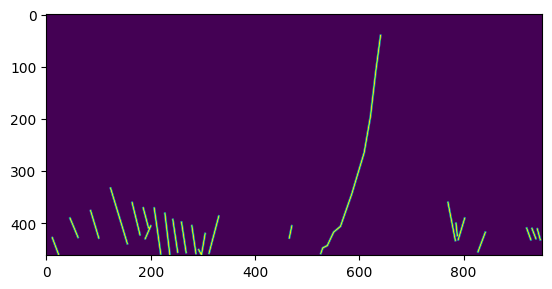

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(Ftmp2)

In [ ]:
Stmp2 = torch.tensor(data[200])

In [ ]:
Stmp2.shape

torch.Size([462, 951])

In [ ]:
Ftmp2.shape

torch.Size([462, 951])

In [ ]:
torch.save({'Seis200': Stmp2, 'Mask200': Ftmp2}, '/content/drive/MyDrive/RW/LIC_TCM/datasets/F3_200.pt')

In [ ]:
data1 = torch.load("/content/drive/MyDrive/RW/LIC_TCM/datasets/F3_200.pt")

<ipython-input-7-bd4aec563c1f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data1 = torch.load("/content/drive/MyDrive/RW/LIC_TCM/datasets/F3_200.pt")


In [ ]:
data1["Seis200"].shape

torch.Size([462, 951])

In [ ]:
data1

{'Seis200': tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
         ...,
         [0.4866, 0.4873, 0.4875,  ..., 0.5493, 0.5390, 0.5350],
         [0.4877, 0.4910, 0.5058,  ..., 0.5377, 0.5389, 0.5428],
         [0.5110, 0.5100, 0.5211,  ..., 0.4947, 0.5076, 0.5061]],
        dtype=torch.float64),
 'Mask200': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])}

In [ ]:
import matplotlib.pyplot as plt

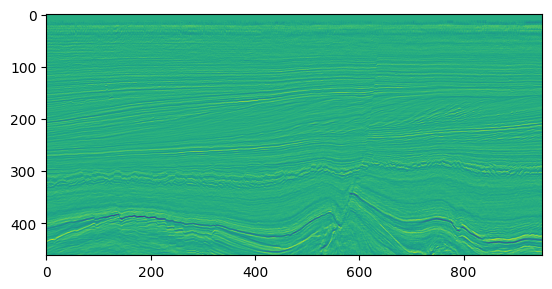

In [ ]:
plt.imshow(data1["Seis200"])

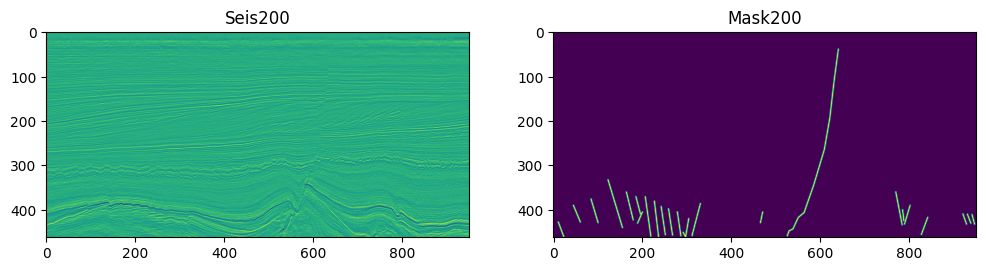

In [ ]:
# prompt: plot data1["Seis200"] and data1["Mask200"]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(data1["Seis200"])
axes[0].set_title("Seis200")

axes[1].imshow(data1["Mask200"])
axes[1].set_title("Mask200")

plt.show()


In [ ]:
# prompt: make 10 patches of size 500 x 500 from data1["Seis200"]

def get_patches(data1):
  patches = []
  shift = 0
  for j in range(5):

    patch = data1[:462, shift : 500+shift ]
    shift += 100
    plt.imshow(patch)

    patches.append(patch)
  patches_tensors = [torch.from_numpy(patch) if isinstance(patch, np.ndarray) else patch for patch in patches]
  patches_tensor = torch.stack(patches_tensors)
  return patches_tensor

In [ ]:
data1["Seis200"].shape

torch.Size([462, 951])

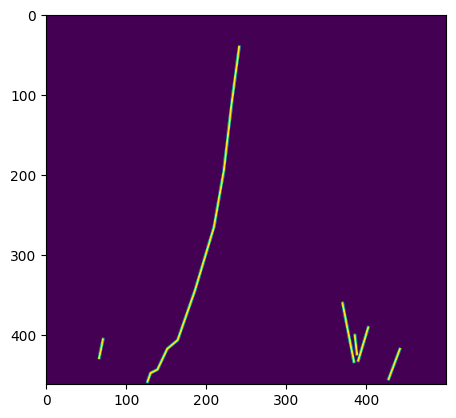

In [ ]:
Stmp2_1 = get_patches(data1["Seis200"])
Ftmp2_1 = get_patches(data1["Mask200"])

In [ ]:
data1["Mask200"].shape

torch.Size([462, 951])

In [ ]:
import matplotlib.pyplot as plt

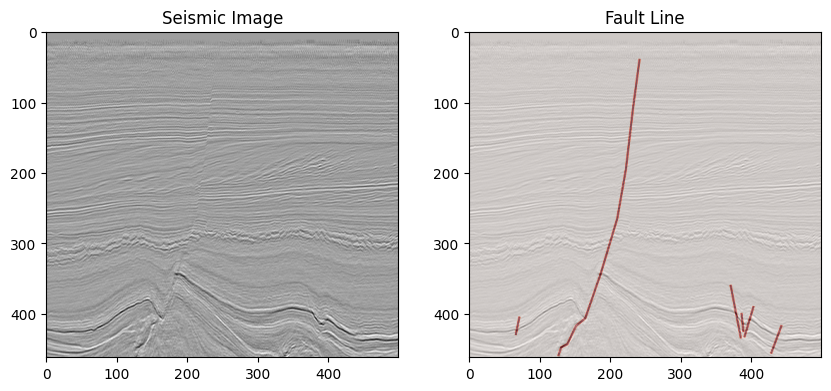

In [ ]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(Stmp2_1[4], cmap='gray')
ax1.set_title('Seismic Image')


ax2.imshow(Stmp2_1[4]*10, cmap='gray')


ax2.imshow(Ftmp2_1[4], cmap="Reds", alpha=0.5)
# ax2.imshow(Stmp2 * 10 - Ftmp2, cmap='gray')
ax2.set_title('Fault Line')
plt.show()


In [ ]:
# run X2
Stmp2 = Ftmp2_1.unsqueeze(0).unsqueeze(0)
Ftmp2 = Ftmp2_1.unsqueeze(0).unsqueeze(0)

In [ ]:
Stmp2 = Ftmp2_1
Ftmp2 = Ftmp2_1

In [ ]:
print(Stmp2.shape)
print(Ftmp2.shape)

torch.Size([5, 462, 500])
torch.Size([5, 462, 500])


In [ ]:
Stmp2.min(), Stmp2.max()

(tensor(0.), tensor(1.))

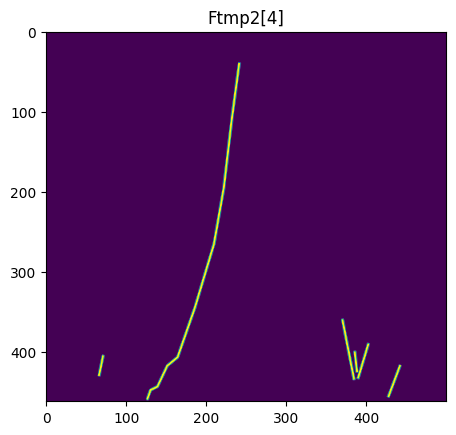

In [ ]:
# prompt: plot ftmp2[w]

w = 4  # Choose the desired index for Ftmp2
plt.imshow(Ftmp2[w])
plt.title(f"Ftmp2[{w}]")
plt.show()


In [ ]:
from re import X
import torch
import torch.nn.functional as F
from torchvision import transforms
#from models import TCM
import warnings
import torch
import os
import sys
import math
import argparse
import warnings
import time
from pytorch_msssim import ms_ssim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

warnings.filterwarnings("ignore")

print(torch.cuda.is_available())


def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return -10 * math.log10(1-ms_ssim(a, b, data_range=1).item())

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

def compute_bpp1(size_bits,num_pixels ):
    """
    Compute bits per pixel (BPP) directly from the compressed image output.

    Parameters:
    - compressed_data_size: Size of the compressed data in bits.
    - image_size: Tuple representing the dimensions of the original image (height, width).

    Returns:
    - bpp: Bits per pixel (BPP) value.
    """

        # Convert the tensor to a byte array
    #compressed_bytes = compressed_im.tobytes()

    # Calculate the size of the byte array in bits
    #compressed_data_size = len(compressed_bytes)

    # # Determine the number of elements in the tensor

    # num_elements = compressed_im.numel()

    # # Determine the number of bits per element based on the data type
    # bits_per_element = compressed_im.element_size() * 8

    # # Calculate the total size in bits
    # size_in_bits = num_elements * bits_per_element


    # num_pixels = image_shape[0] * image_shape[1] * image_shape[2]
    # Calculate the bits per pixel value
    bpp = (size_bits*8) / num_pixels
    return bpp

def compute_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Square Error (RMSE) between two arrays.

    Parameters:
    y_true (list or numpy array): The actual values.
    y_pred (list or numpy array): The predicted values.

    Returns:
    float: The computed RMSE value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the mean squared error (MSE)
    mse = np.mean((y_true - y_pred) ** 2)

    # Take the square root of MSE to get RMSE
    rmse_value = np.sqrt(mse)

    return rmse_value

def pad(x, p):
    h, w = x.size(2), x.size(3)
    new_h = (h + p - 1) // p * p
    new_w = (w + p - 1) // p * p
    padding_left = (new_w - w) // 2
    padding_right = new_w - w - padding_left
    padding_top = (new_h - h) // 2
    padding_bottom = new_h - h - padding_top
    x_padded = F.pad(
        x,
        (padding_left, padding_right, padding_top, padding_bottom),
        mode="constant",
        value=0,
    )
    return x_padded, (padding_left, padding_right, padding_top, padding_bottom)

def crop(x, padding):
    return F.pad(
        x,
        (-padding[0], -padding[1], -padding[2], -padding[3]),
    )

def parse_args(argv):
    parser = argparse.ArgumentParser(description="Example testing script.")
    parser.add_argument("--cuda", action="store_true", help="Use cuda")
    parser.add_argument(
        "--clip_max_norm",
        default=1.0,
        type=float,
        help="gradient clipping max norm (default: %(default)s",
    )
    parser.add_argument("--checkpoint", type=str, help="Path to a checkpoint")
    parser.add_argument("--data", type=str, help="Path to dataset")
    parser.add_argument(
        "--real", action="store_true", default=True
    )
    parser.set_defaults(real=False)
    args = parser.parse_args(argv)
    return args
op0 = []
op1 = []
op2 = []
op3 = []
op4 = []
op5 = []
op6 = []
TIME = []
my_dict = {}

QP = [0.000000005,0.000005,0.005,0.5,0.7,1,3.5,5,8,10]
# QP = [5,3.5,2,0.5,0.9,0.7,0.005]
#QP1 = [1000,50,40,10,1,0.5,0.05,0.0005,0.0000005]

def Eval(argv , data_index):
    PS = []
    BR = []
    MS = []
    RMSE = []
    compresed_mask = []
    bench = {}
    args = parse_args(argv)
    p = 128
    path = args.data
    img_list = []
    for file in os.listdir(path):
        if file[-3:] in ["jpg", "png", "peg"]:
            img_list.append(file)
    if args.cuda:
        device = 'cuda:0'
    else:
        device = 'cpu'
    net = TCM(config=[2,2,2,2,2,2], head_dim=[8, 16, 32, 32, 16, 8], drop_path_rate=0.0, N=256, M=320, qp = 0.001)
    # net = TCM3C(config=[2,2,2,2,2,2], head_dim=[8, 16, 32, 32, 16, 8], drop_path_rate=0.0, N=128, M=320, qp = 0.001)
    net = net.to(device)
    net.eval()
    count = 0
    PSNR = 0
    Bit_rate = 0
    MS_SSIM = 0
    total_time = 0
    dictory = {}

    if args.checkpoint:  # load from previous checkpoint
        print("Loading", args.checkpoint)
        checkpoint = torch.load(args.checkpoint, map_location=device)
        for k, v in checkpoint["state_dict"].items():
            dictory[k.replace("module.", "")] = v
        net.load_state_dict(dictory)

    if args.real:
        for qp in QP:

            psnr = []
            bitR = []
            mssim = []
            time_ = []
            net.update()

            input_seis = Stmp2[data_index].unsqueeze(0)
            gnd_seis = Ftmp2[data_index].unsqueeze(0)
            x = input_seis.unsqueeze(0)
            y = gnd_seis.unsqueeze(0)

            x_padded, padding = pad(x, p)
            y_padded, padding = pad(y, p)

            count += 1
            with torch.no_grad():
                if args.cuda:
                    torch.cuda.synchronize()
                s = time.time()

                out_enc = net.compress(x_padded,qp)

                out_dec = net.decompress(out_enc["strings"], out_enc["shape"])
                op1.append(out_enc)


                if args.cuda:
                    torch.cuda.synchronize()
                e = time.time()
                total_time += (e - s)

                out_dec["x_hat"] = crop(out_dec["x_hat"], padding)
                op2.append(out_dec)

                num_pixels = x.size(0) * x.size(2) * x.size(3)

                #resized_tensor1 = torch.nn.functional.interpolate(x, size=(200, 200), mode='bilinear')
                #resized_tensor2 = torch.nn.functional.interpolate(out_net['x_hat'], size=(200, 200), mode='bilinear')

                tmp0 = sum(len(s[0]) for s in out_enc["strings"]) * 8.0 / num_pixels
                print("compress data bytes(Encoder)",sum(len(s[0]) for s in out_enc["strings"]))

                compressed_im = out_dec["x_hat"][0][0]
                compressed_im = compressed_im.numpy()
                print(compressed_im.shape)

                #quality = 100  # Adjust the quality value as needed
                # _, encoded_image = cv2.imencode('.png', compressed_im)

                # cv2.imwrite(f"/content/drive/MyDrive/RW/LIC_TCM/salt/np1Comp{i}q{q}.png",np_im1)
                # encoded_bytes = encoded_image.tobytes()
                #compressed_data_size = compressed_im.size*compressed_im.itemsize*8

                # print("compress data bytes",len(encoded_bytes))

                # tmp0 = compute_bpp1(len(encoded_bytes), num_pixels)

                tmp1 = compute_ssim(y, out_dec["x_hat"] )
                tmp2 = compute_psnr1(y, out_dec["x_hat"])
                tmp3 = compute_rmse(y, out_dec["x_hat"])

                Bit_rate += tmp0
                PSNR += tmp2
                MS_SSIM += tmp1

                print(f'Time: {(total_time)}')
                print(f'Bitrate: {(tmp0):.3f}bpp')
                print(f'MS-SSIM: {(tmp1):.2f}dB')
                print(f'PSNR: {(tmp2):.2f}dB')


                BR.append(tmp0)
                RMSE.append(tmp3)
                PS.append(tmp2)
                MS.append(tmp1)
                TIME.append(total_time)


                print("Decompressed Image")
                compressed_im = out_dec["x_hat"][0]
                plt.imshow(compressed_im[0], cmap = "gray")
                compresed_mask.append(compressed_im[0])
                print(compressed_im.shape)
                plt.show()

          # PS.append(psnr)
          # MS.append(mssim)
          # BR.append(bitR)
          # TIME.append(time_)

    bench["PSNR"] = PS
    bench["RMSE"] = RMSE
    bench["MS-SSIM"] = MS
    bench["Bitrate"] = BR
    bench["Time"] = TIME

    return bench, compresed_mask, input_seis, gnd_seis


False


## QP based Fault RD

In [ ]:
Stmp2 = Stmp2.float()

[2, 2, 2, 2, 2, 2]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Loading /content/drive/MyDrive/RW/LIC_TCM/fault/0.025checkpoint_latest_1.pth.tar
qpTCM : 5e-09
compress data bytes(Encoder) 20460
(462, 500)
Time: 91.3342866897583
Bitrate: 0.709bpp
MS-SSIM: 0.92dB
PSNR: 18.31dB
Decompressed Image
torch.Size([1, 462, 500])


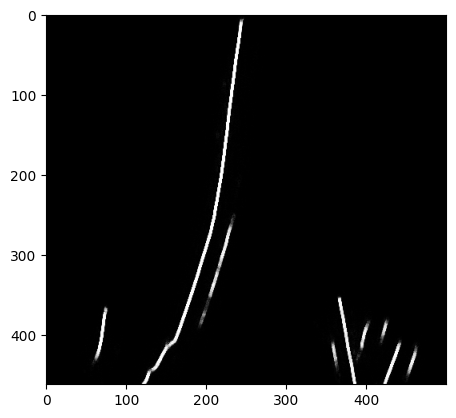

qpTCM : 5e-06
compress data bytes(Encoder) 20460
(462, 500)
Time: 186.71568989753723
Bitrate: 0.709bpp
MS-SSIM: 0.92dB
PSNR: 18.31dB
Decompressed Image
torch.Size([1, 462, 500])


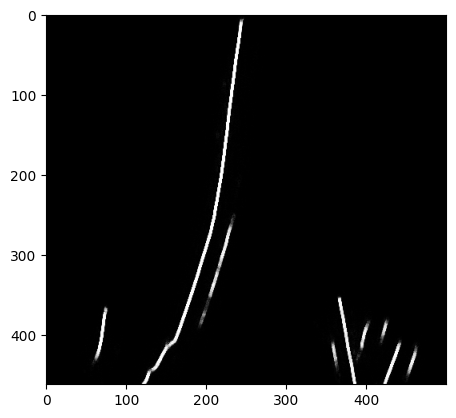

qpTCM : 0.005
compress data bytes(Encoder) 20276
(462, 500)
Time: 276.71503615379333
Bitrate: 0.702bpp
MS-SSIM: 0.92dB
PSNR: 18.29dB
Decompressed Image
torch.Size([1, 462, 500])


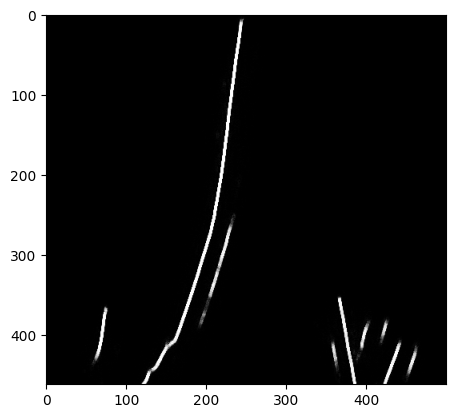

qpTCM : 0.5
compress data bytes(Encoder) 12536
(462, 500)
Time: 365.97029852867126
Bitrate: 0.434bpp
MS-SSIM: 0.92dB
PSNR: 18.25dB
Decompressed Image
torch.Size([1, 462, 500])


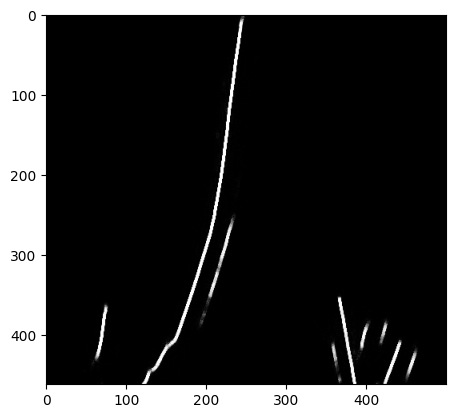

qpTCM : 0.7
compress data bytes(Encoder) 42176
(462, 500)
Time: 472.8866603374481
Bitrate: 1.461bpp
MS-SSIM: 0.92dB
PSNR: 18.46dB
Decompressed Image
torch.Size([1, 462, 500])


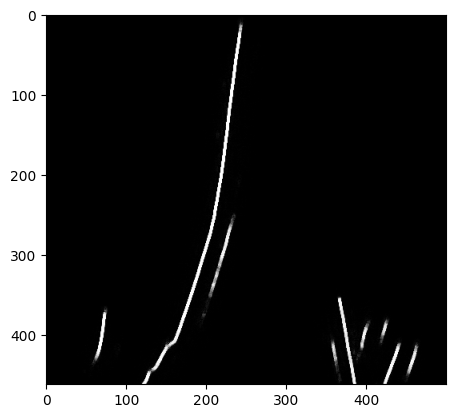

qpTCM : 1
compress data bytes(Encoder) 20460
(462, 500)
Time: 568.8929407596588
Bitrate: 0.709bpp
MS-SSIM: 0.92dB
PSNR: 18.31dB
Decompressed Image
torch.Size([1, 462, 500])


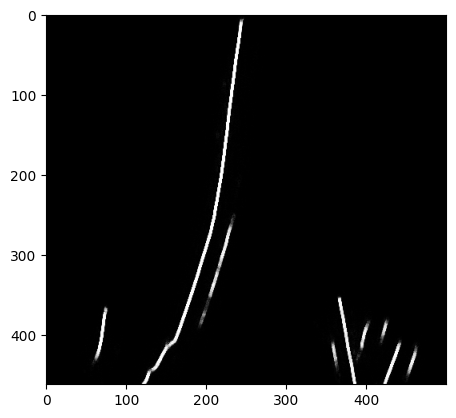

qpTCM : 3.5
compress data bytes(Encoder) 5228
(462, 500)
Time: 657.4425792694092
Bitrate: 0.181bpp
MS-SSIM: 0.92dB
PSNR: 18.33dB
Decompressed Image
torch.Size([1, 462, 500])


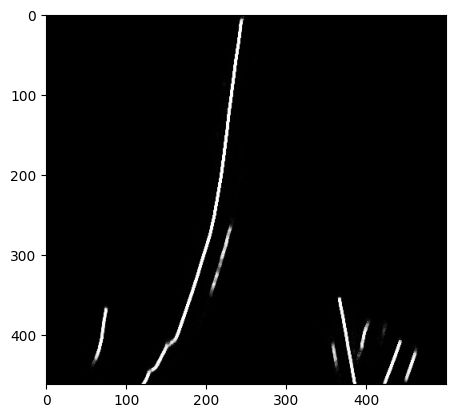

qpTCM : 5
compress data bytes(Encoder) 3704
(462, 500)
Time: 747.4953339099884
Bitrate: 0.128bpp
MS-SSIM: 0.94dB
PSNR: 19.07dB
Decompressed Image
torch.Size([1, 462, 500])


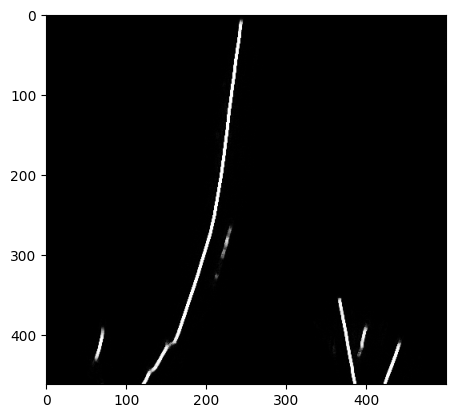

qpTCM : 8
compress data bytes(Encoder) 2532
(462, 500)
Time: 846.4061994552612
Bitrate: 0.088bpp
MS-SSIM: 0.94dB
PSNR: 19.05dB
Decompressed Image
torch.Size([1, 462, 500])


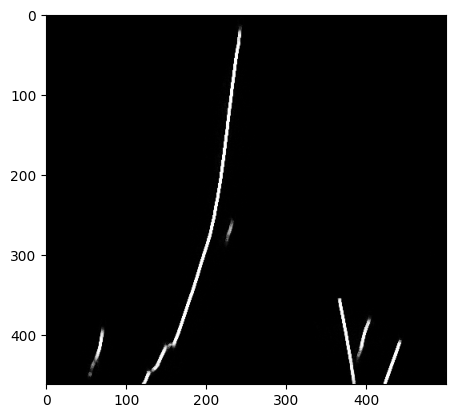

qpTCM : 10
compress data bytes(Encoder) 2124
(462, 500)
Time: 940.0771813392639
Bitrate: 0.074bpp
MS-SSIM: 0.94dB
PSNR: 19.10dB
Decompressed Image
torch.Size([1, 462, 500])


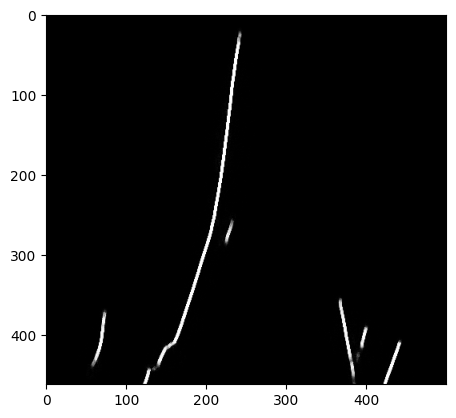

In [ ]:

arg =[ '--checkpoint', '/content/drive/MyDrive/RW/LIC_TCM/fault/0.025checkpoint_latest_1.pth.tar', '--real']
data_index = 1
bench1, compresed_mask1, input_seis1, gnd_seis1 = Eval(arg, data_index)

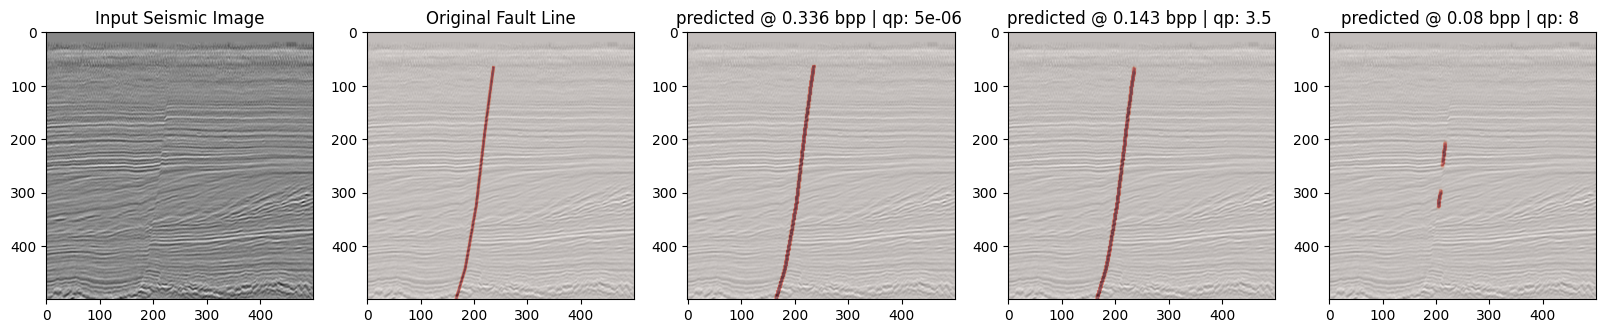

In [ ]:
# prompt: plot Stmp2, and Ftmp2 side by side
bench2 = bench0

fig, (ax_orig, ax_gn, ax2, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 6))
ax_orig.imshow(input_seis[0], cmap='gray')
ax_orig.set_title('Input Seismic Image')

# Plot the seismic data
ax_gn.imshow(input_seis[0]*10, cmap='gray')
ax_gn.imshow(gnd_seis[0], cmap="Reds", alpha=0.5)

ax_gn.set_title(f'Original Fault Line')
# Create a colormap for the mask
# cmap = colors.LinearSegmentedColormap.from_list("my_colormap", ["white", "red"])


ax2.imshow(input_seis[0]*10, cmap='gray')
ax2.imshow(compresed_mask[1], cmap="Reds", alpha=0.5)
bpp = round(bench2['Bitrate'][1], 3)
qp = QP[1]
ax2.set_title(f'predicted @ {bpp} bpp | qp: {qp} ')
# ax2.axis('off')

# Plot the seismic data
# ax3.imshow(input_seis[]*10, cmap='gray')
# ax3.imshow(compresed_mask[], cmap="Reds", alpha=0.5)
# bpp = round(bench2['Bitrate'][5], 3)
# qp = QP[5]
# ax3.set_title(f'predicted @ {bpp} bpp | qp: {qp} ')
# Plot the mask over the seismic data
ax4.imshow(input_seis[0]*10, cmap='gray')
ax4.imshow(compresed_mask[6], cmap="Reds", alpha=0.5)
bpp = round(bench2['Bitrate'][6], 3)
qp = QP[6]
ax4.set_title(f'predicted @ {bpp} bpp | qp: {qp} ')
# ax2.imshow(Stmp2 * 10 - Ftmp2, cmap='gray')
ax5.imshow(input_seis[0]*10, cmap='gray')
ax5.imshow(compresed_mask[8], cmap="Reds", alpha=0.5)
bpp = round(bench2['Bitrate'][8], 3)
qp = QP[8]
ax5.set_title(f'predicted @ {bpp} bpp | qp: {qp} ')


# plt.axis('off')
plt.show()
